In [42]:
%load_ext autoreload
%autoreload 2

from src.data import load_data
from src.plots import *
from src.functions import *
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Trend and Moving Averages

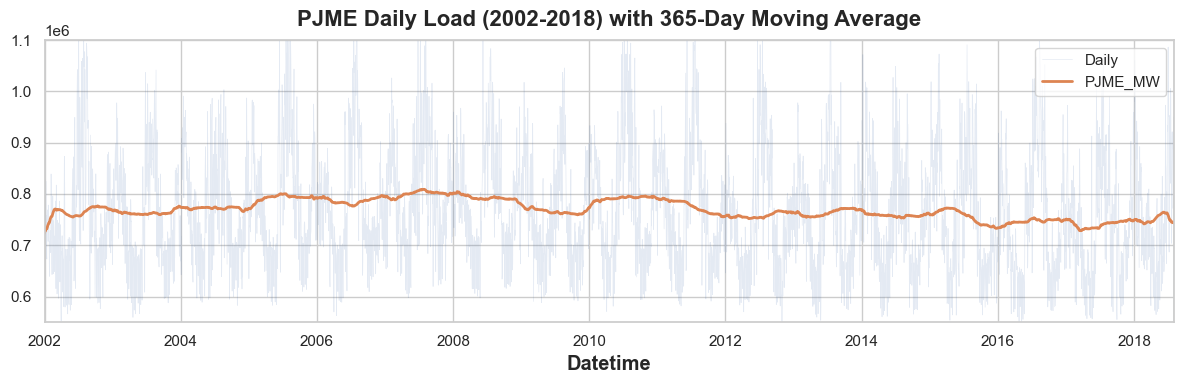

In [43]:
trends = load_data(to_period=True)

moving_average_year = trends.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = trends["PJME_MW"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_year.plot(ax=ax, lw=2, label="365-day MA")
ax.set_title("PJME Daily Load (2002-2018) with 365-Day Moving Average")
ax.set_ylim(550000, 1100000)  # optional zoom
ax.legend()
plt.savefig("../reports/figures/365-day-MA.png")

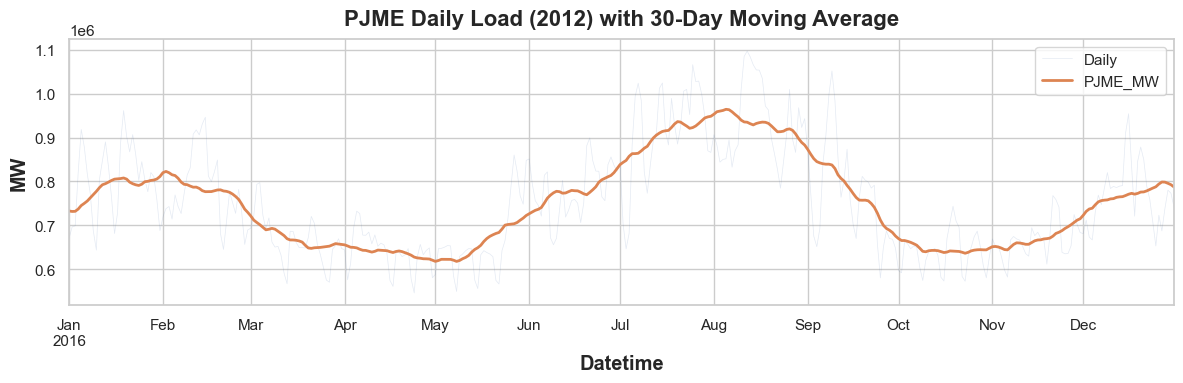

In [44]:
moving_average_month = trends.rolling(
    window=30,
    center=True,
    min_periods=15,
).mean()

ax = trends["PJME_MW"].loc["2016-01":"2016-12"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_month.loc["2016-01":"2016-12"].plot(ax=ax, lw=2, label="30-day MA")
ax.set_title("PJME Daily Load (2012) with 30-Day Moving Average")
ax.set_ylabel("MW")
ax.legend()
plt.savefig("../reports/figures/30-day-MA.png")

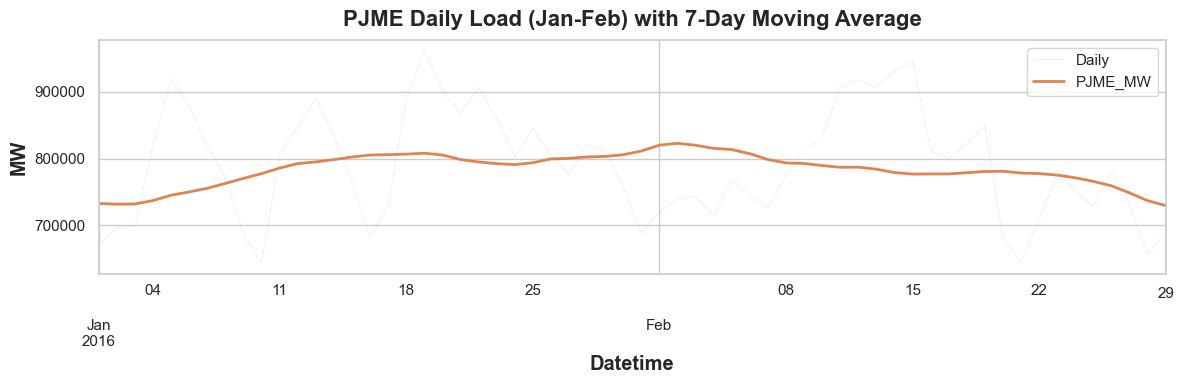

In [45]:
moving_average_week = trends.rolling(
    window=7,
    center=True,
    min_periods=3,
).mean()

ax = trends["PJME_MW"].loc["2016-01":"2016-02"].plot(figsize=(12,4), alpha=0.15, lw=0.5, label="Daily")
moving_average_month.loc["2016-01":"2016-02"].plot(ax=ax, lw=2, label="7-day MA")
ax.set_title("PJME Daily Load (Jan-Feb) with 7-Day Moving Average")
ax.set_ylabel("MW")
ax.legend()
plt.savefig("../reports/figures/7-day-MA.png")

# Let's add Fourier features

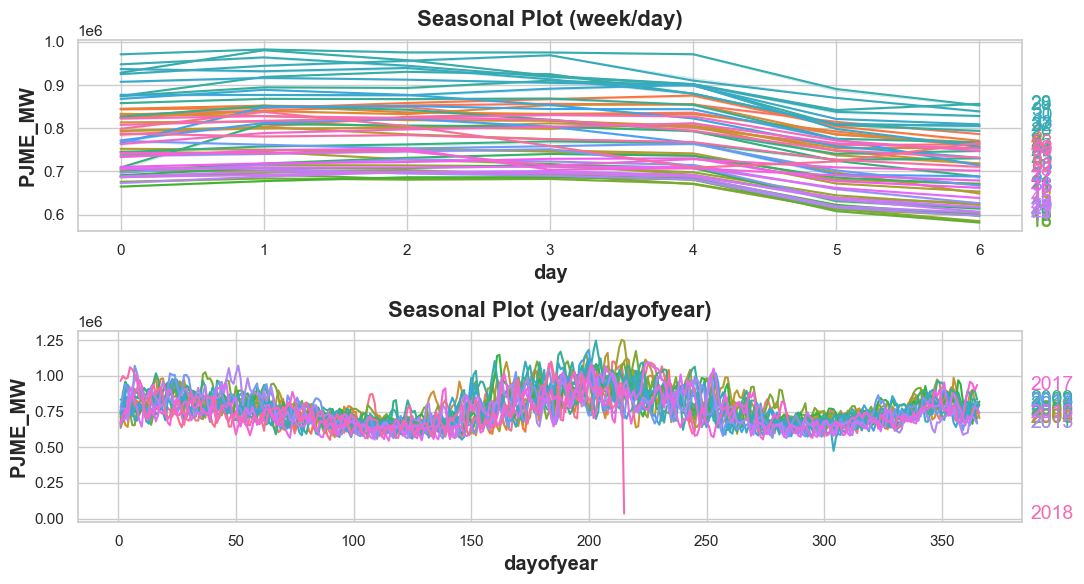

In [46]:
X = load_data(to_period=True)

# days within a week
X['day'] = X.index.dayofweek
X['week'] = X.index.week

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="PJME_MW", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="PJME_MW", period="year", freq="dayofyear", ax=ax1)
plt.savefig("../reports/figures/seasonal_plots.png")

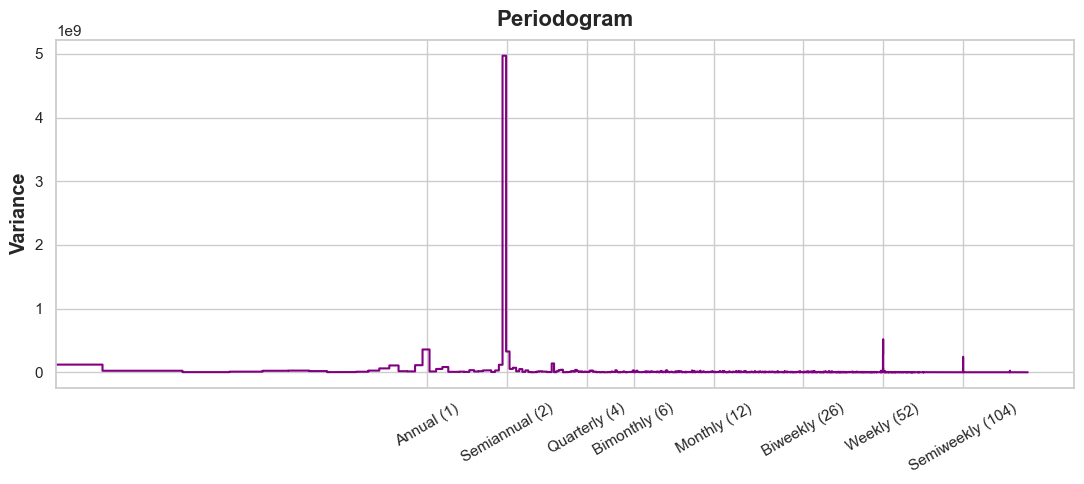

In [47]:
plot_periodogram(X.PJME_MW)
plt.savefig("../reports/figures/periodogram.png")

Periodogram shows huge spike at semiannual and noticeable variance at annual and weekly

## Pipeline to create deterministic/fourier features:

In [48]:
y = load_data(to_period=True)

train_start="2002-01-01"
train_end="2016-12-31"
test_start = "2017-01-01"
test_end = "2018-08-03"

dp, X_dp, det_model, y_fit, y_resid, X_dp_train = make_deterministic_features(y, order=2, fourier_order=5, train_start=train_start, train_end=train_end)

y_train = y[train_start:train_end]
y_test = y[test_start:test_end]

X_dp_test = X_dp[test_start:test_end]
y_pred = pd.DataFrame(det_model.predict(X_dp_test), index=X_dp_test.index)

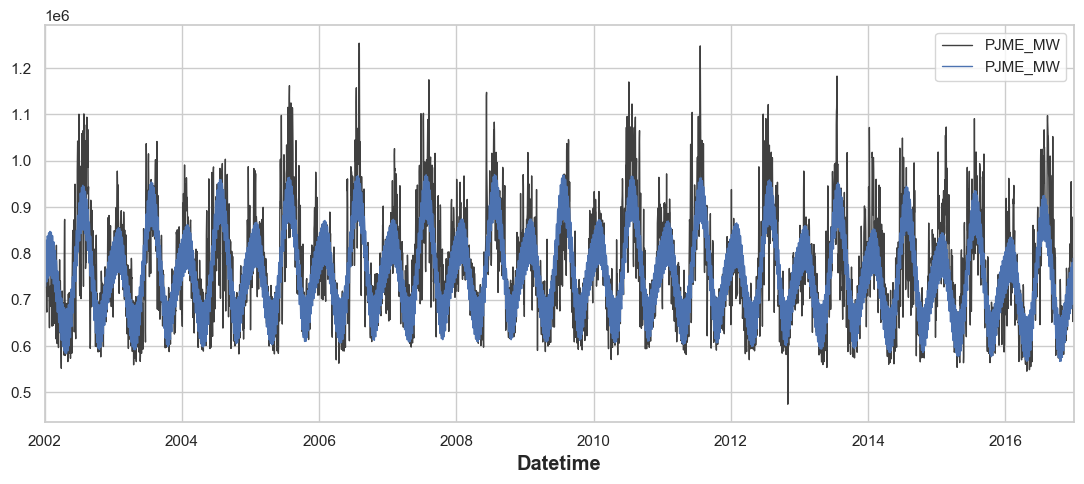

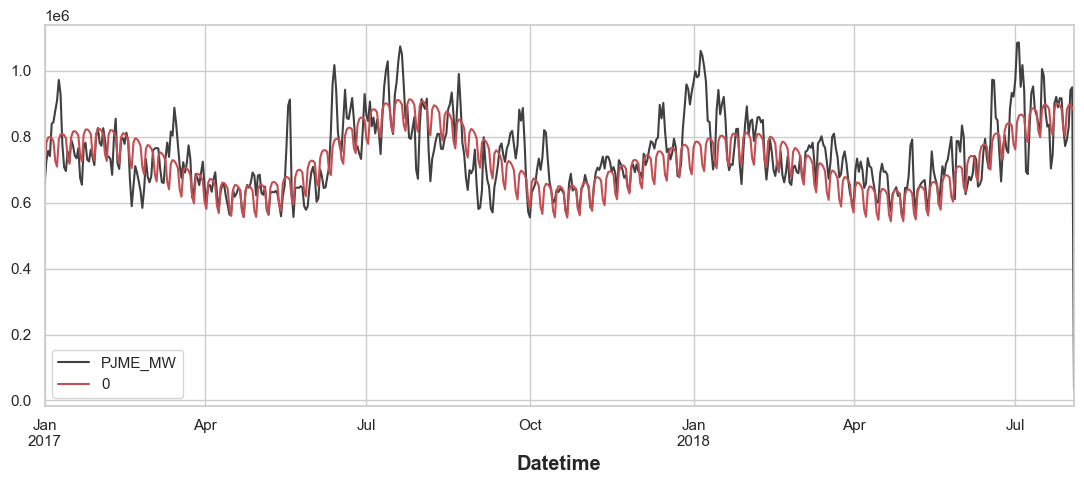

In [49]:

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, linewidth=1)
axs1 = y_test.plot(color='0.25', subplots=True, sharex=True)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs, linewidth=1)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs1)

### Next, create residual features

In [50]:
y = load_data(to_period=True)


# calendar features
calendar_df = pd.DataFrame(index=y.index)
calendar_df["dow"] = y.index.dayofweek
calendar_df["is_weekend"] = (calendar_df["dow"] >= 5).astype(int)
calendar_df["month"] = y.index.month


# holiday?
us_holidays = holidays.US(years=range(y.index.min().year, y.index.max().year+1))


X_resid_full = make_residual_features(y, calendar_df=calendar_df, holidays=us_holidays)

X_resid is shifted so we need to align it with y_resid

In [51]:
# keep only rows with full lag/rolling features
X_resid = X_resid_full.dropna()

X_resid_train = X_resid[train_start:train_end]
X_resid_test = X_resid[test_start:test_end]


# align
idx = X_resid_train.index.intersection(y_resid.index)
X_resid_train = X_resid_train.loc[idx]
y_resid = y_resid.loc[idx]


In [52]:
print(X_resid_train.shape, y_resid.shape)
print(y_resid.isna().sum())

(5115, 16) (5115, 1)
PJME_MW    0
dtype: int64


In [53]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xr_train_scaled = scaler.fit_transform(X_resid_train)

now, fit forest model

In [54]:
xgb = XGBRegressor(random_state=42)
xgb.fit(Xr_train_scaled, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

trained model on residual features and residuals from deterministic model..
now predict on test residuals

In [55]:
# align indices
idx2 = y_pred.index.intersection(X_resid_test.index)

# deterministic baseline as a Series (grab first column)
y_deter_test = y_pred.iloc[:, 0].reindex(idx2)

# scale test features
Xr_test_scaled = scaler.transform(X_resid_test.loc[idx2, X_resid_train.columns])

# predict residuals
r_test = pd.Series(xgb.predict(Xr_test_scaled), index=idx2, name="resid_pred")

# hybrid forecast
y_hybrid_test = y_deter_test.add(r_test, fill_value=0)

In [56]:
y_hybrid_test

Datetime
2017-01-01    655482.183225
2017-01-02    678909.654245
2017-01-03    744266.672039
2017-01-04    754706.173304
2017-01-05    760270.476844
                  ...      
2018-07-30    801481.514232
2018-07-31    808525.168901
2018-08-01    849949.743235
2018-08-02    977423.265605
2018-08-03    930396.334613
Freq: D, Length: 580, dtype: float64

### Next, evaluate predictions

In [57]:
import numpy as np
import pandas as pd

# truth & the two model forecasts, aligned
y_true = y.loc[y_hybrid_test.index]
y_true = y_true.iloc[:, 0]
y_det = y_deter_test.loc[y_hybrid_test.index]
y_hybrid = y_hybrid_test

eval_df = pd.concat(
    [y_true.rename("y_true"), y_det.rename("y_det"), y_hybrid.rename("y_hybrid")],
    axis=1
).dropna()

# metrics
def mae(y, yhat):  return np.mean(np.abs(y - yhat))
def rmse(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat): return np.mean(np.abs((y - yhat) / y)) * 100

results = pd.DataFrame({
    "MAE":  [mae(y_true, y_det),    mae(y_true, y_hybrid)],
    "RMSE": [rmse(y_true, y_det),   rmse(y_true, y_hybrid)],
    "MAPE": [mape(y_true, y_det),   mape(y_true, y_hybrid)],
}, index=["Deterministic", "Hybrid"])

print(results.round(3))

                     MAE       RMSE    MAPE
Deterministic  62017.233  88148.052  11.925
Hybrid         50407.510  72743.595  10.837


Next, evaluate against naïve baselines

In [58]:
# baselines, aligned to test window
naive_1d = y_true.shift(1).reindex(eval_df.index)
naive_7d = y_true.shift(7).reindex(eval_df.index)

eval_2 = pd.concat(
    [eval_df[["y_true", "y_det", "y_hybrid"]],
    naive_1d.rename("naive_1d"),
    naive_7d.rename("naive_7d")],
    axis=1).dropna()


# metrics
naive = pd.DataFrame({
    "MAE": [mae(eval_2["y_true"], eval_2["naive_1d"]),
            mae(eval_2["y_true"], eval_2["naive_7d"])],
    "RMSE": [rmse(eval_2["y_true"], eval_2["naive_1d"]),
             rmse(eval_2["y_true"], eval_2["naive_7d"])],
    "MAPE": [mape(eval_2["y_true"], eval_2["naive_1d"]),
             mape(eval_2["y_true"], eval_2["naive_7d"])],
}, index=["Naive-1D", "Naive-7D"])

# combine with earlier results
results_all = pd.concat([results, naive]).round(3)
print(results_all)

                     MAE        RMSE    MAPE
Deterministic  62017.233   88148.052  11.925
Hybrid         50407.510   72743.595  10.837
Naive-1D       47952.386   71577.560  10.717
Naive-7D       79265.272  110389.141  14.528


### Visualization:

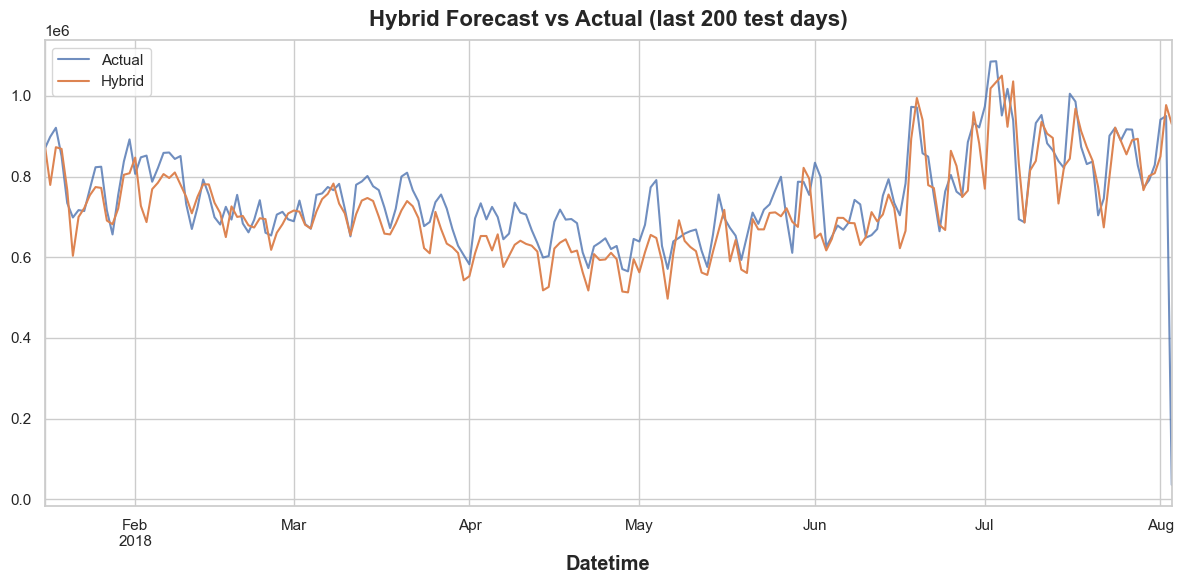

In [59]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["y_hybrid"].iloc[-200:].plot(ax=ax, label="Hybrid")

ax.set_title("Hybrid Forecast vs Actual (last 200 test days)")
ax.legend()
plt.savefig("../reports/figures/Hybrid-forecast.png")

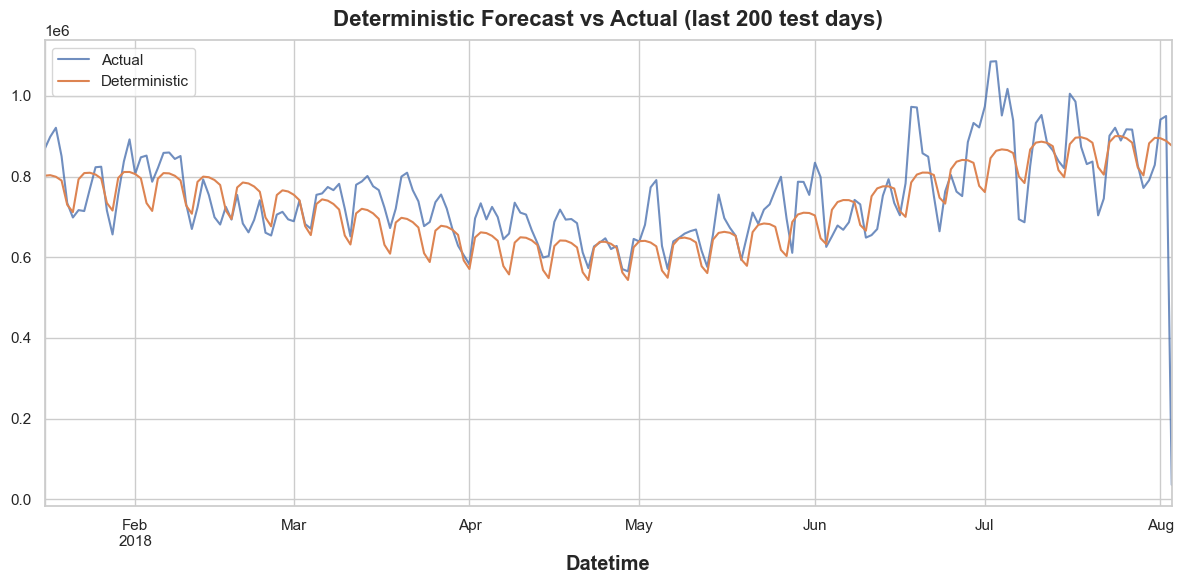

In [60]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["y_det"].iloc[-200:].plot(ax=ax, label="Deterministic")

ax.set_title("Deterministic Forecast vs Actual (last 200 test days)")
ax.legend()
plt.savefig("../reports/figures/Deterministic-forecast.png")

Hybrid model performed a lot better than the regular model

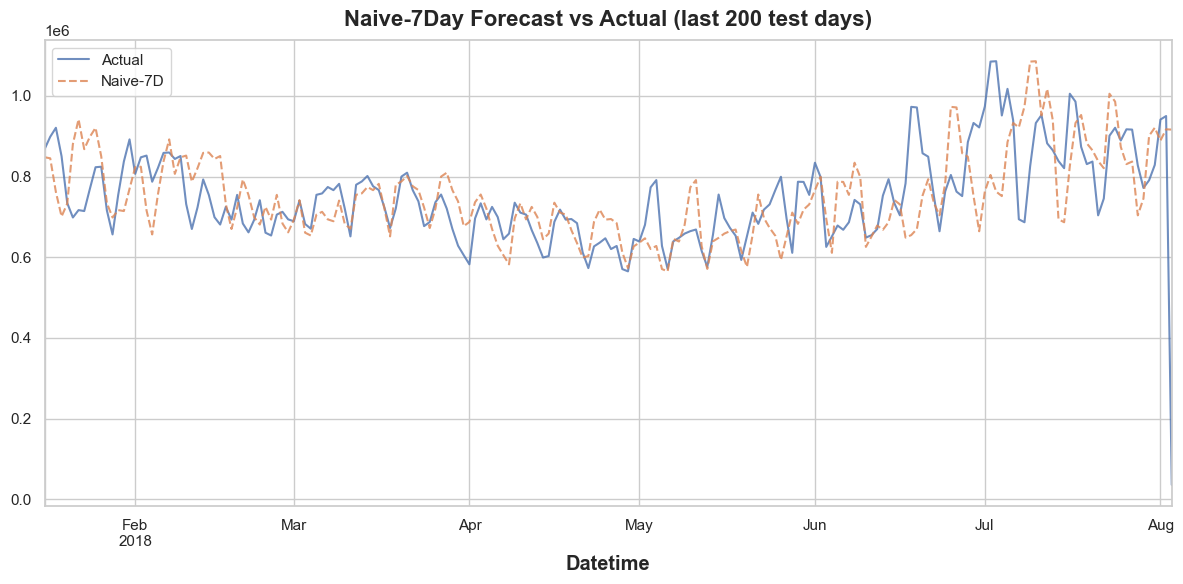

In [61]:
ax = eval_2["y_true"].iloc[-200:].plot(label="Actual", figsize=(12,6), alpha=0.8)
eval_2["naive_7d"].iloc[-200:].plot(ax=ax, label="Naive-7D", linestyle="--", alpha=0.8)

ax.set_title("Naive-7Day Forecast vs Actual (last 200 test days)")
ax.legend()
plt.savefig("../reports/figures/naive7d-forecast.png")